# Notes on conductivity circuit development

## 2016-2-2

### Wien Oscillator + Charge Pump + ADC Conductivity Circuit

*Wien oscillators* are simple circuit configurations that generate sinusoidal output.  For a nice guide to these and related circuits for generating sine wave output, see: 

- http://www.ti.com/lit/an/sloa060/sloa060.pdf
- http://www.electronics-tutorials.ws/oscillator/wien_bridge.html
- https://en.wikipedia.org/wiki/Wien_bridge_oscillator
- adjustible-frequency wien oscillator: https://www.maximintegrated.com/en/app-notes/index.mvp/id/3846
- http://www.learnabout-electronics.org/Oscillators/osc34.php

### Prototype

Our approach is based entirely on the circuit here: https://github.com/SparkysWidgets/MinieCHW/blob/master/MinieCV1_2.pdf

Focusing in on the main part of the circuit:

<img src="https://raw.githubusercontent.com/p-v-o-s/conductivity-research/master/images/op-amp.png">

Most of our time has been spent building the circuit around the quad op-amp.

#### Saturation

I'm observing saturation at around 3.8 V.  I've now realized that this is likely the limit of op amp output for this particular op amp.  
For the <a href="http://www.ti.com/lit/ds/symlink/tl072.pdf">TL07xx</a> op amp, at VCC=5V, max output is ~ 3V: <img src="https://raw.githubusercontent.com/OpenWaterProject/conductivity-research/master/images/TL07MaxPeakOutput.png">

So this explains the saturation.  We might need to go to rail-to-rail (or dial in better input / amplification range).  But in general, we'll need to figure out the appropriate amplification circuitry for various anticipated solution conductivity values. 

The amplification happens on pins 5,6, and 7 of the op-amp in the circuit above.  Looking at this part of the circuit, we see that the op-amp is in a standard 'non-inverted amplifier' configuration:

<img src="https://upload.wikimedia.org/wikipedia/commons/6/66/Operational_amplifier_noninverting.svg">

(Image is from a Wikipedia entry on [op-amps](https://en.wikipedia.org/wiki/Operational_amplifier).)

The equation for the gain, $G$, is:

$G = 1 + R_f/R_g$

Where $R_f$ = "R9" in our circuit diagram above, and $R_g$ is the resistance provided by the probe in the water.  

### Analysis
We chose a value of 40KOhm for R9 ("$R_g$") in our particular amplifier circuit.  We ended up hitting the "rail" (saturation point) of the op amp for all but the least conductive solutions, so it's time to dig into what amplification behavior we expect, given various values of $R_f$. Some notes:

- Input voltage is ~ 250 mV.  (This is the voltage out of "OSCVout" in the above circuit diagram, i.e. the input to pin 5 on the op-amp.  
- **Q**: do we measure the same voltage on pin 6 if we put it on the scope?
- Gain G = 1 + R_f/R_w
- The R_f we chose was 40K
- Testing a 80 uS led to a voltage output of around 0.25 volts
- Testing 1400 uS led to a voltage output of around 2.5 volts
- should we measure V_in to get an accurate sense of what's going into the water? Is this a way to do the four-probe thing?
- $V_{out} / V_{in} = 1+R_f/R_g$
- $R_f/((V_{out} / V_{in} - 1)) = R_g$
Note that if R_g >>> R_f, we expect that V_out ~= V_in.  We saw that for 80 uS, so that probably means that we need a larger resistor for R_f if we want to measure solutions with such low conductivity values. 

For the 1400 uS solution, we measured 2.5 volts.  That's a gain G of 10X, since the input was 0.25 volts.
So $G=10$, and $R_g=R_f/((G - 1))$.  So R_g equals ...

In [15]:
R_f=40
G=10
R_g=R_f/((G - 1)); R_g

4.444444444444445

That's about 4K -- interpreted as the resistance between the terminals on the probe in the water. We'll need to estimate a cell constant.

### Analyzing the amplifier subcircuit

Let's get a sense for the behavior of the amplification circuit for our chosen value of $R_f = 40K$ by plotting the gain $G$ as a function of $R_f$ for a range of resistance values R_water ...

In [2]:
%matplotlib inline 
# above line allows for showing plots in a cell easily
import matplotlib # the main plotting library
import numpy as np # allows for arrays
import matplotlib.pyplot as plt # getting specific plotting functions

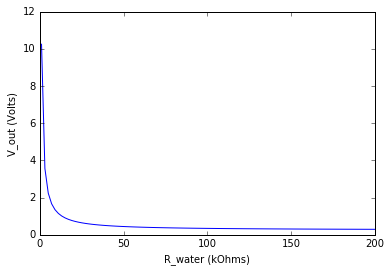

In [6]:
R_water = np.linspace(1, 200, 100)  # 1 .. 200 kOhms
V_in = 0.250 # mV
Rf = 40 # kOhms
y = V_in*(1+(Rf/R_water))
plt.plot(R_water,y)
plt.xlabel('R_water (kOhms)')
plt.ylabel('V_out (Volts)')

We put in 0.25 volts, and we hit the op-amp rail (3 Volts) for the highest conductivity solution.  That's a G value of:

What value of $R_g$ ("R_water") would get us to such an amplification (or higher)?

### Envelope

We need to dial in the proper capacitor and resistor for the envelope circuit formed by D1, R10, and C7.  We chose R10 = 100K, and varied C7.

Guides to selecting R and C in a diode detector circuit:

- http://seniord.ee.iastate.edu/SSOL/RADAR/prjpln99/detector3.html
- https://www.st-andrews.ac.uk/~www_pa/Scots_Guide/RadCom/part9/page2.html


For C7 = 10uF, the envelope was smooth, but the response was relatively slow:

In [37]:
from IPython.display import HTML 
HTML('<iframe width="560" height="315" src="//www.youtube.com/embed/bkJ653KVroY?rel=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


For C7=0.1uF, the response was fast, but because of this, the enve

In [38]:
from IPython.display import HTML 
HTML('<iframe width="560" height="315" src="//www.youtube.com/embed/bq6PUedEDyg?rel=0&amp;showinfo=0" rel="0" frameborder="0" allowfullscreen></iframe>')


This might imply that 1uF would be a good compromise.

### Time trace

In anticipation of collecting CSV data, here's some code for loading a CSV file from a local repo ...

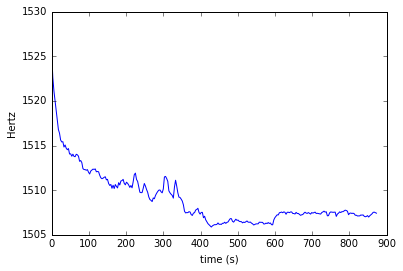

In [5]:
%matplotlib inline 
# above line allows for showing plots in a cell easily
import matplotlib # the main plotting library
import numpy as np # allows for arrays
import matplotlib.pyplot as plt # getting specific plotting functions
import urllib # URL import functions
import pandas as pd # nice data utilities

# below code is for reading from URL
#url='https://raw.githubusercontent.com/dwblair/sage_test/master/test3.csv' # the url for the CSV
#response = urllib.request.urlopen(url) # treating the URL as a file
#a=pd.read_csv(response,names=['t','c']) # reading that file in as a CSV


a=pd.read_csv('./data/test3.csv',names=['t','c']) # reading that file in as a CSV
t=np.array(a['t']); c=np.array(a['c']); # convert the imported data into arrays
plt.plot(t,c);plt.xlabel('time (s)'); plt.ylabel('Hertz') #plot, and add x and y labels

## Next steps:

- Need to figure out what range of R_f will be appropriate for which solutions
- How to control R_f? Digital potentiometer? Switch?
- Need to modify hardware to all run at 3.3V:  appropriate op-amp and charge pump.
- Think about how amplifier on ADC might be used in place of potentiometer

## Notes


- nice reference on op-amps and slew rate: http://www.ti.com/lit/an/sloa039a/sloa039a.pdf <-- also has a current to voltage converter in Fig 15!
- http://www.instructables.com/answers/How-to-use-an-op-amp/
- http://forum.arduino.cc/index.php?topic=225949.0
- http://www.ti.com/ww/en/bobpease/assets/AN-31.pdf
- designing amplifier circuits -- avoiding common problems: http://www.analog.com/media/en/technical-documentation/application-notes/AN-937.pdf
- guide to op amp amplification: http://www.avrfreaks.net/forum/dc-amplifier-opamp-lm358-problem
- how to bias an op-amp: http://ocw.mit.edu/courses/media-arts-and-sciences/mas-836-sensor-technologies-for-interactive-environments-spring-2011/readings/MITMAS_836S11_read02_bias.pdf
- connecting op amps to adcs - 'digital conversion' - http://www.analog.com/library/analogDialogue/archives/39-05/Web_Ch3_final.pdf
- buffer op amp to adc circuits -- http://www.ti.com/lit/an/sloa098/sloa098.pdf
- nice op amp definitions / guide -- http://www.nutsvolts.com/magazine/article/op-amp-cookbook
- nice notes on the 741 op amp, with applications: http://www.jamia-physics.net/lecnotes/lab/opamp.pdf

##  2016-02-07

Playing with the RTC.  
- Wake up at a specific time
- Turn on a switch
- Sleep 
- Repeat
- Do first with interrupt pin D2 or D3; then do with D5 


1. Wake up from sleep by pulling RTC pin high
- Using the Mizraith RTC library: https://github.com/mizraith/RTClib

using wake_up -- best option so far

http://forum.arduino.cc/index.php?topic=109062.0

https://github.com/JChristensen/DS3232RTC/issues/5

no pullup resistor needed if pull up set in code

wake_up_3:
https://gist.github.com/dwblair/ba5572d622e9ba1bd996

http://playground.arduino.cc/Learning/ArduinoSleepCode

sleep: https://lowpowerlab.com/forum/index.php?topic=286.0

with sleepy or low power sketch, gets .4 mA while sleeping -- so that's 220 days. 

2200 mAh / .4 mA = 230 days

n mosfet:
https://www.adafruit.com/datasheets/irlb8721pbf.pdf
http://bildr.org/2012/03/rfp30n06le-arduino/


### final version:
https://gist.github.com/dwblair/2076508bafa39d2f31b2
which requires: https://github.com/JChristensen/DS3232RTC and https://github.com/rocketscream/Low-Power





### four probe

current sensing:
http://www.eetimes.com/document.asp?doc_id=1279415

http://www.digikey.com/product-detail/en/ACS712ELCTR-05B-T/620-1189-1-ND/1284606
http://www.kr4.us/acs712-breakout.html?gclid=Cj0KEQiA89u1BRDz8enExq7rvN0BEiQAaFCHm5eZ6dk15SzvApmohdP57VAbtY5NLVK2kn9_MWFtexAaAhtR8P8HAQ

better:
https://www.sparkfun.com/products/12040

even better:
INA219
https://www.adafruit.com/products/904

complete front end:
http://www.analog.com/media/en/technical-documentation/data-sheets/AD7719.pdf

http://www.digikey.com/product-search/en/integrated-circuits-ics/data-acquisition-analog-front-end-afe/2556395

http://www.digikey.com/product-detail/en/MCP3911A0-E%2FSS/MCP3911A0-E%2FSS-ND/3046611
http://ww1.microchip.com/downloads/en/DeviceDoc/20002286C.pdf

http://ww1.microchip.com/downloads/en/DeviceDoc/25048B.pdf

http://www.ti.com/lit/ds/symlink/ads1291.pdf

MCP3911:
http://ww1.microchip.com/downloads/en/DeviceDoc/20002286C.pdf
$2
http://forum.arduino.cc/index.php?topic=176201.0

fancier, similar chip:
http://ww1.microchip.com/downloads/en/DeviceDoc/25048B.pdf


TI biometrics:
http://www.ti.com/lit/ds/symlink/ads1291.pdf


analog diagram for ph and conductivity using analog front ends:
http://www.analog.com/media/cn/technical-documentation/apm-pdf/adi-water-analysis-solutions_en.pdf

https://www.researchgate.net/publication/3094201_A_Four-Terminal_Water-Quality-Monitoring_Conductivity_Sensor

full circuit design!
http://www.analog.com/media/en/reference-design-documentation/reference-designs/CN0359.pdf
http://www.farnell.com/datasheets/1903445.pdf

good background:
http://www.analytical-chemistry.uoc.gr/files/items/6/618/agwgimometria_2.pdf

usgs:
http://pubs.usgs.gov/wsp/2311/report.pdf

analog sesor conditioning circuits:
http://ww1.microchip.com/downloads/en/AppNotes/00990a.pdf


thesis: around figure 7, some specific circuits:
http://eprints.soton.ac.uk/143801/1.hasCoversheetVersion/Ocean_Sensors_for_Marine_Enviromental_Monitoring.pdf

http://www.octiva.net/projects/ppm/

https://bitknitting.wordpress.com/

https://bitknitting.wordpress.com/category/conductivity/

this is the nice circuit:
http://www.excelpoint.com.cn/ADIsite/pdf/solutions/adi-demo-system-and-solutions_en_r.pdf

woah -- everything!!
http://www.analog.com/en/design-center/reference-designs/hardware-reference-design/circuits-from-the-lab/CN0349.html#rd-overview

doesn't look too bad:
http://www.analog.com/media/en/reference-design-documentation/reference-designs/CN0349.pdf
http://www.analog.com/media/en/reference-design-documentation/reference-designs/CN0359.pdf

this is huge:
http://www.analog.com/media/en/reference-design-documentation/reference-designs/CN0349.pdf


### general

dyad or dryad --> data repository 
